In [92]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import pylab as plot

a = '改掉SOH定義的資料集_noerror.csv'
data = np.genfromtxt(a, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, invalid_raise = False, encoding = 'latin-1')
[Row,Column] = data.shape
print(data[0:3,:])

[[ 5.9916668e+01  2.2200000e+03 -2.3300000e-01  1.1700000e+03
   8.0069000e+00  1.5000000e+03  8.7500000e+00]
 [ 6.0583336e+01  2.2200000e+03 -2.1400000e-01  1.2300000e+03
   7.9929000e+00  1.7100000e+03  8.6700000e+00]
 [ 6.0000000e+01  2.2200000e+03 -2.3300000e-01  7.9600000e+02
   8.0034000e+00  1.5700000e+03  8.7300000e+00]]


In [93]:
features_train2, features_test2, soh_train2, soh_test2 = train_test_split(data[:,[1,2,3,4,5,6]], data[:,0], test_size=0.2, random_state=100)
print("features_train2\n", features_train2)
print("soh_train2\n", soh_train2)     #檢查格式是否正確,才不會讓ML程式垮掉

features_train2
 [[ 1.9490e+03 -2.6200e-01  7.2800e+02  8.1100e+00  1.3100e+03  8.7600e+00]
 [ 1.2940e+03 -3.2600e-01  1.7900e+02  8.7734e+00  7.0100e+02  8.8900e+00]
 [ 1.6690e+03 -3.2000e-01  6.8200e+02  8.2499e+00  1.0800e+03  8.8800e+00]
 ...
 [ 2.2100e+03 -2.1000e-01  8.1200e+02  8.0780e+00  1.5000e+03  8.6600e+00]
 [ 1.4570e+03 -2.9900e-01  2.4700e+02  8.4793e+00  9.0200e+02  8.8400e+00]
 [ 1.7770e+03 -2.4900e-01  6.9500e+02  8.1788e+00  1.0500e+03  8.7500e+00]]
soh_train2
 [49.77778  24.777777 42.416668 ... 56.02778  32.38889  44.36111 ]


# BRR

In [94]:
from sklearn import linear_model     # BayesianRidge
import time
t1 = time.monotonic()

params_Baye = {"n_iter":700 , "tol":0.01, "alpha_1":1e-04, "alpha_2":1e-06, "lambda_1":1e-06, "lambda_2":1e-06}   # ,"n_iter":100 , "tol":0.01, "alpha_2":1e-06, "lambda_1":1e-06, "lambda_2":1e-06
model = linear_model.BayesianRidge(tol=0.0001, fit_intercept=False, compute_score=True)   # 
model.set_params(**params_Baye)
model.fit(features_train2, soh_train2)
prediction = model.predict(features_test2)
RMSE = np.round(math.sqrt(mean_squared_error(soh_test2, prediction)),3)
MAE = np.round(mean_absolute_error(soh_test2, prediction),3)
R_sq = np.round(r2_score(soh_test2, prediction),3)
Residual = prediction-soh_test2
print("Residual", Residual)

t2 = time.monotonic()
print("time elapsed:" + str(np.round(t2-t1,3)) + " seconds")

Residual [ 1.57605618  2.05712879  1.08646829 ...  2.55616028 -0.30146438
  0.89742458]
time elapsed:0.015 seconds


low_ci_bound
 [28.40602367 29.97042828 41.44421178 ... 22.21945977 48.50072211
 38.39405807]
high_ci_bound
 [35.91275669 37.4771613  48.9509448  ... 29.72619279 56.00745513
 45.90079109]
std of the SOH
  =  0.146


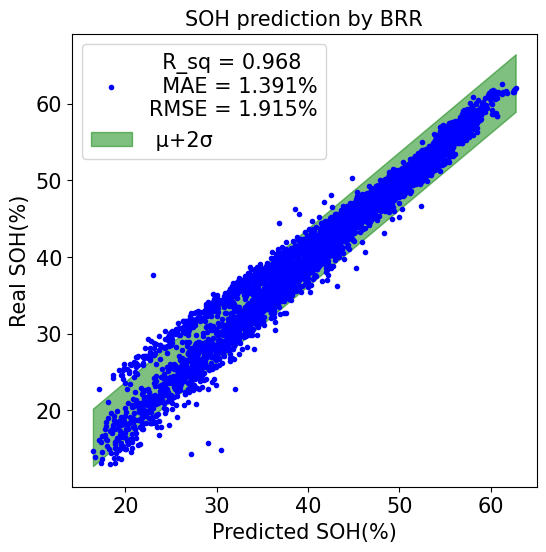

In [96]:
'''加信賴區間後的圖'''
import seaborn as sns
import matplotlib
import scipy.stats as st
matplotlib.rcParams.update({'font.size': 15})

# predicted expect and calculte confidence interval
low_ci_bound, high_ci_bound = st.t.interval(0.95, len(prediction),
                                           loc=prediction,scale=Residual.std())
print("low_ci_bound\n", low_ci_bound)
print("high_ci_bound\n", high_ci_bound)
print("std of the SOH\n  = ", np.round(st.sem(prediction),3))

# plot confidence interval
plt.figure(figsize=(6,6), dpi = 100)   #
plt.plot(prediction,soh_test2, color='blue', linestyle='None' , marker='.', label=f'  R_sq = {R_sq}\n  MAE = {MAE}%\nRMSE = {RMSE}%')
plt.fill_between(sorted(prediction), sorted(low_ci_bound), sorted(high_ci_bound), color='green', alpha=0.5,
                label=' μ+2σ')   #  ' μ+2σ', color='blue', linestyle='None' , marker='.'
plt.xlabel("Predicted SOH(%)", fontsize=15) 
plt.ylabel("Real SOH(%)", fontsize=15)
plt.tick_params(labelsize=15)
plt.legend(fontsize=15)
plt.title("SOH prediction by BRR", fontsize=15)   #_No relaxationno VPVD
#plt.grid()
plt.show()

Sampling Mean: 0.027
Sampling StdErr: 1.915
95% Confidence Interval: [-3.726  3.779]


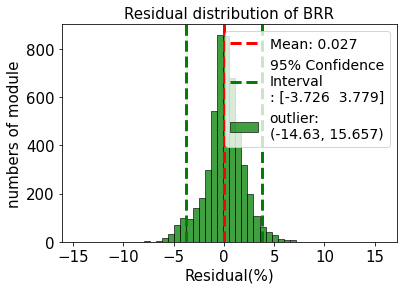

In [105]:
'''Residuals'''
from scipy import stats

# 取得 X_mean 的 mean, std, 95% 信賴區間
m = Residual.mean()                  # X_bar 的平均
se = Residual.std()                  # 標準誤
ci = np.round(stats.norm.interval(0.95, m, se),3)   # return [m - 1.96 std, m + 1.96 std]
rmax = np.round(np.max(Residual),3)
rmin = np.round(np.min(Residual),3)

print (f'Sampling Mean: {m:.3f}')
print (f'Sampling StdErr: {se:.3f}')
print (f'95% Confidence Interval: {ci}')

sns.histplot(Residual, color='green', bins=50, kde=False, label=f'outlier:\n{rmin, rmax}')
plt.axvline(m, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m:.3f}')
plt.axvline(ci[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci}')
plt.axvline(ci[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Residual(%)', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Residual distribution of BRR', fontsize=15)   #_No relaxation_no VPVD
plt.legend(fontsize=14);
#plt.grid(); 
plt.show()

Sampling Mean: 0.006
Sampling StdErr: 0.069
95% Confidence Interval: [-0.129  0.141]


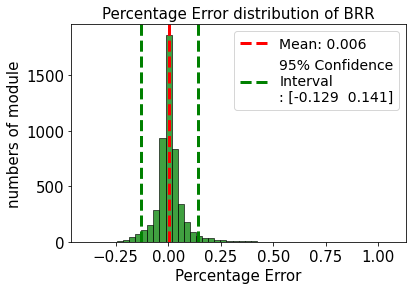

In [99]:
'''Percentage Error'''
pep_brr = Residual/soh_test2

# 取得 X_mean 的 mean, std, 95% 信賴區間
m1 = pep_brr.mean()                  # X_bar 的平均
se1 = pep_brr.std()                  # 標準誤
ci1 = np.round(stats.norm.interval(0.95, m1, se1),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m1:.3f}')
print (f'Sampling StdErr: {se1:.3f}')
print (f'95% Confidence Interval: {ci1}')

sns.histplot(pep_brr, color='green', bins=50, kde=False)
plt.axvline(m1, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m1:.3f}')
plt.axvline(ci1[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci1}')
plt.axvline(ci1[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Percentage Error', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Percentage Error distribution of BRR', fontsize=15)   #_No relaxation_no VPVD
plt.legend(fontsize=14);
#plt.grid();
plt.show()

In [ ]:
 -------------------------------------------------------存最佳的模型就好--------------------------------------------------------

In [ ]:
file_BRR = np.asarray([soh_test2,prediction,Residual]).T
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\2023 0327改soh後ML模型&結果\1_BRR預測結果.csv',file_BRR,fmt='%s',delimiter=',')
print("BRR", file_BRR)   #_No relaxation

# RF

In [159]:
t1 = time.monotonic()
startime = time.ctime(); startime = startime.split()
print("start time: ", startime[1:4])

rmseoos = []
ntreelist = range(1050, 1100, 50)
for itrees in ntreelist:
    depth = None
    maxft = 2
    model = ensemble.RandomForestRegressor(n_estimators=itrees, max_depth=depth, max_features=maxft, oob_score=False, random_state=100)
    model.fit(features_train2, soh_train2)
    predictions = model.predict(features_test2)
    rmseoos.append(math.sqrt(mean_squared_error(soh_test2, predictions)))
R_sq = np.round(model.fit(features_train2, soh_train2).score(features_test2, soh_test2),3)
MAE = np.round(mean_absolute_error(predictions,soh_test2),3)
RMSE = np.round(np.sqrt(mean_squared_error(predictions,soh_test2)),3)
Residuals = predictions-soh_test2
print("Residuals = ", Residuals)    #print("Best RMSE(%) = ", min(rmseoos))

t2 = time.monotonic()
print("time elapsed: " + str(np.round(t2-t1,3)) + " seconds")

start time:  ['Mar', '28', '16:27:15']
Residuals =  [ 0.45068684  2.01367818  1.52389054 ... -0.60841175 -0.05208747
  1.52367679]
time elapsed: 88.219 seconds


low_ci_bound
 [28.42443205 31.07075539 43.02541175 ... 20.19866546 49.89387674
 40.164088  ]
high_ci_bound
 [33.64360964 36.28993297 48.24458933 ... 25.41784305 55.11305433
 45.38326558]
std of the SOH
  =  0.147


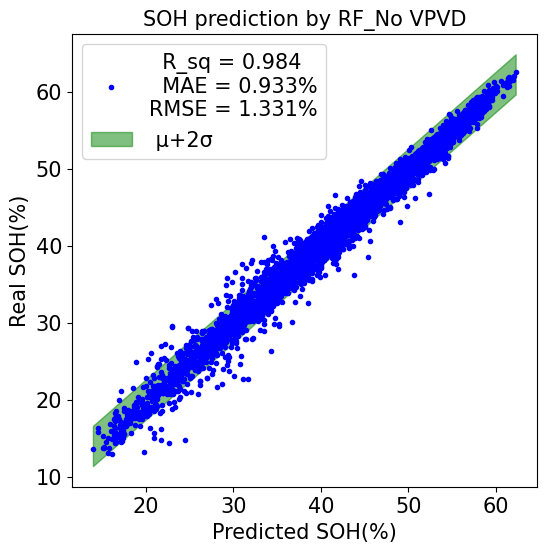

In [161]:
'''加信賴區間後的圖'''
matplotlib.rcParams.update({'font.size': 15})

# predicted expect and calculte confidence interval
low_ci_bound, high_ci_bound = st.t.interval(0.95, len(predictions),
                                           loc=predictions,scale=Residuals.std())
print("low_ci_bound\n", low_ci_bound)
print("high_ci_bound\n", high_ci_bound)
print("std of the SOH\n  = ", np.round(st.sem(predictions),3))

# plot confidence interval
plt.figure(figsize=(6,6),dpi=100)
plt.plot(predictions,soh_test2, color='blue', linestyle='None' , marker='.', label=f'  R_sq = {R_sq}\n  MAE = {MAE}%\nRMSE = {RMSE}%')
plt.fill_between(sorted(predictions), sorted(low_ci_bound), sorted(high_ci_bound),
                 color='green', alpha=0.5, label=' μ+2σ')
plt.tick_params(labelsize=15)
plt.xlabel("Predicted SOH(%)", fontsize=15) #15
plt.ylabel("Real SOH(%)", fontsize=15)
plt.legend(fontsize=15)
plt.title("SOH prediction by RF_No VPVD", fontsize=15)   #_No relaxation
#plt.grid()
plt.show()

Sampling Mean: 0.006
Sampling StdErr: 1.331
95% Confidence Interval: [-2.603  2.615]


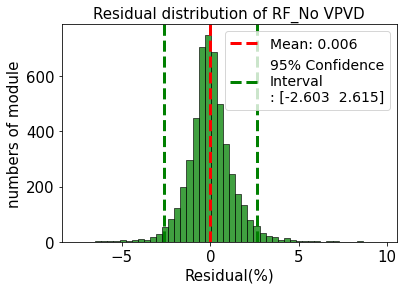

In [162]:
'''Residuals'''
from scipy import stats

# 取得 X_mean 的 mean, std, 95% 信賴區間
m = Residuals.mean()                  # X_bar 的平均
se = Residuals.std()                  # 標準誤
ci = np.round(stats.norm.interval(0.95, m, se),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m:.3f}')
print (f'Sampling StdErr: {se:.3f}')
print (f'95% Confidence Interval: {ci}')

sns.histplot(Residuals, color='green', bins=50, kde=False)
plt.axvline(m, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m:.3f}')
plt.axvline(ci[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci}')
plt.axvline(ci[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Residual(%)', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Residual distribution of RF_No VPVD', fontsize=15)   #_No relaxation
plt.legend(fontsize=14);
#plt.grid();
plt.show()

Sampling Mean: 0.003
Sampling StdErr: 0.044
95% Confidence Interval: [-0.085  0.09 ]


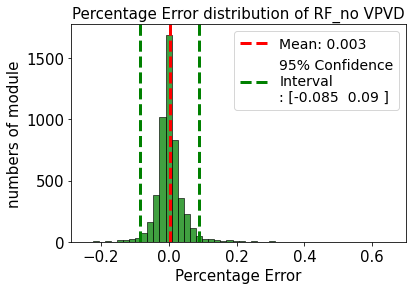

In [163]:
'''Percentage Error'''
pep_rf = Residuals/soh_test2

# 取得 X_mean 的 mean, std, 95% 信賴區間
m2 = pep_rf.mean()                  # X_bar 的平均
se2 = pep_rf.std()                  # 標準誤
ci2 = np.round(stats.norm.interval(0.95, m2, se2),3)   # return [m - 1.96 std, m + 1.96 std]

print (f'Sampling Mean: {m2:.3f}')
print (f'Sampling StdErr: {se2:.3f}')
print (f'95% Confidence Interval: {ci2}')

sns.histplot(pep_rf, color='green', bins=50, kde=False)
plt.axvline(m2, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {m2:.3f}')
plt.axvline(ci2[0], color='green', linestyle='dashed', linewidth=3, label=f'95% Confidence\nInterval\n: {ci2}')
plt.axvline(ci2[1], color='green', linestyle='dashed', linewidth=3)
plt.xlabel('Percentage Error', fontsize=15)
plt.ylabel('numbers of module', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Percentage Error distribution of RF_no VPVD', fontsize=15)   #_No relaxation
plt.legend(fontsize=14);
#plt.grid();
plt.show()

In [ ]:
 -------------------------------------------------------存最佳的模型就好--------------------------------------------------------

In [ ]:
file_RF = np.asarray([soh_test2,predictions,Residuals]).T
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\2023 0327改soh後ML模型&結果\2_RF預測結果.csv',file_RF,fmt='%s',delimiter=',')
print("FNN", file_RF)   #_No relaxation

In [ ]:
from yellowbrick.model_selection import FeatureImportances
visualizer = FeatureImportances(model,labels=["CHR_Time","3min relaxation","inflection time","V15min","DIS0_Time","VPVD"])
visualizer.fit(features_train2, soh_train2)     #, dpi=100
visualizer.show()

C:\Users\Chun-Po\miniconda3\envs\env_pytorch\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


Text(0, 0.5, 'RMSE(%)')

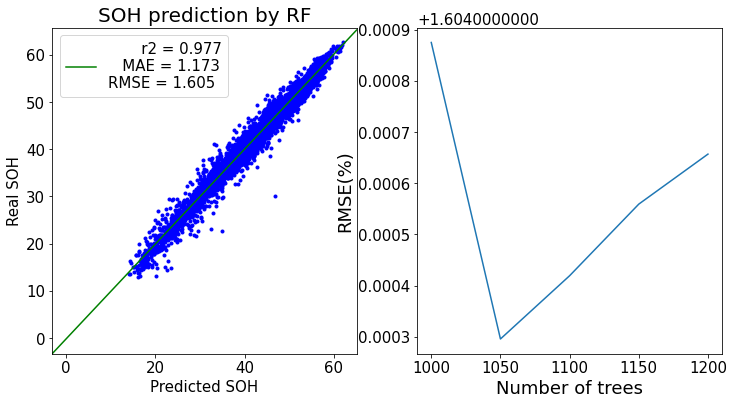

In [108]:
'''Codes for Tuning random forest'''
f = plot.figure(figsize=(12,6))
ax1 = f.add_subplot(121); ax2 = f.add_subplot(122)

ax1.plot(predictions,soh_test2, 'b.')
ax1.set_title("SOH prediction by RF", fontsize=20);
m1, b1 = np.polyfit(predictions,soh_test2.astype(np.float), 1)
ax1.axline(xy1=(0, b1), slope=m1, color='g', label=f'       r2 = {R_sq}\n   MAE = {MAE}\nRMSE = {RMSE}') # 
ax1.set_xlabel("Predicted SOH", fontsize=15) 
ax1.set_ylabel("Real SOH", fontsize=15)
ax1.legend(fontsize=15)

ax2.plot(ntreelist, rmseoos)
ax2.set_xlabel("Number of trees", fontsize=18) # max features at each nodes
ax2.set_ylabel("RMSE(%)", fontsize=18)


# 長條圖

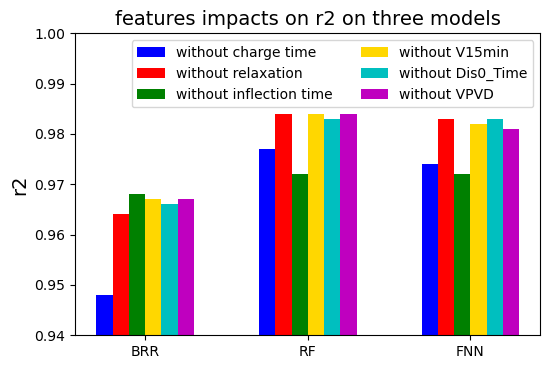

In [1]:
'''r2'''
import matplotlib.pyplot as plt

x1 = [-0.25, 0.75, 1.75]; x4 = ['BRR','RF','FNN']     # [1,2,3,4,5]；[-0.6,-0.4,-0.2,0.2,0.4,0.6]；['BRR','RF','FNN']；[-1.0, 2.0, 5.0]
x2 = [-0.15, 0.85, 1.85]; x5 = [0.15, 1.15, 2.15]
x3 = [-0.05, 0.95, 1.95]; x6 = [0.25, 1.25, 2.25]
lim = 0.94
h1_chr = [0.948-lim, 0.977-lim, 0.974-lim]         # 第1組數據高度 , bottom=0.94
h2_rex = [0.964-lim, 0.984-lim, 0.983-lim]         # 第2組數據高度 , bottom=0.94
h3_inf = [0.968-lim, 0.972-lim, 0.972-lim]         # 第3組數據高度 , bottom=0.94
h4_v15 = [0.967-lim, 0.984-lim, 0.982-lim]         # 第3組數據高度 , bottom=0.94
h5_dis = [0.966-lim, 0.983-lim, 0.983-lim]         # 第3組數據高度 , bottom=0.94
h6_vpv = [0.967-lim, 0.984-lim, 0.981-lim]         # 第3組數據高度 , bottom=0.94 ,dpi=300,fontsize=10

plt.figure(dpi=100)
plt.bar(x1, h1_chr, color='b', bottom=lim, width=0.1, label='without charge time')
plt.bar(x2, h2_rex, color='r', bottom=lim, width=0.1, label='without relaxation')
plt.bar(x3, h3_inf, color='g', bottom=lim, width=0.1, label='without inflection time')
plt.bar(x4, h4_v15, color='gold', bottom=lim, width=0.1, label='without V15min', align='edge')
plt.bar(x5, h5_dis, color='c', bottom=lim, width=0.1, label='without Dis0_Time')
plt.bar(x6, h6_vpv, color='m', bottom=lim, width=0.1, label='without VPVD')
plt.ylim(lim,1.0)
plt.ylabel('r2', fontsize=14)
plt.title('features impacts on r2 on three models', fontsize=14)   #\n
plt.tick_params(labelsize=10)
plt.legend(fontsize=10, ncol=2);
plt.show()

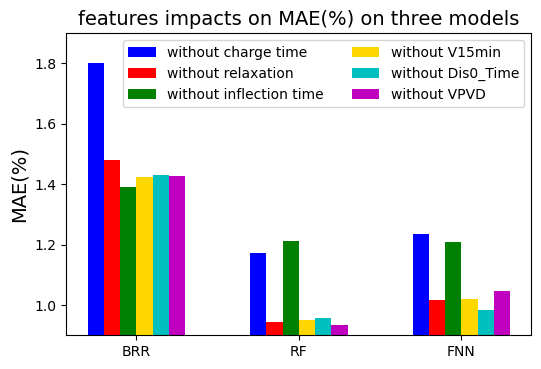

In [2]:
'''MAE'''
import matplotlib.pyplot as plt

x1 = [-0.25, 0.75, 1.75]; x4 = ['BRR','RF','FNN']     # [1,2,3,4,5]；[-0.6,-0.4,-0.2,0.2,0.4,0.6]；['BRR','RF','FNN']；[-1.0, 2.0, 5.0]
x2 = [-0.15, 0.85, 1.85]; x5 = [0.15, 1.15, 2.15]
x3 = [-0.05, 0.95, 1.95]; x6 = [0.25, 1.25, 2.25]
lim = 0.9
h1_chr = [1.803-lim, 1.174-lim, 1.234-lim]         # 第1組數據高度 , bottom=0.94
h2_rex = [1.480-lim, 0.944-lim, 1.016-lim]         # 第2組數據高度 , bottom=0.94
h3_inf = [1.391-lim, 1.213-lim, 1.210-lim]         # 第3組數據高度 , bottom=0.94
h4_v15 = [1.425-lim, 0.951-lim, 1.021-lim]         # 第3組數據高度 , bottom=0.94
h5_dis = [1.432-lim, 0.957-lim, 0.985-lim]         # 第3組數據高度 , bottom=0.94
h6_vpv = [1.429-lim, 0.933-lim, 1.045-lim]         # 第3組數據高度 , bottom=0.94 ,dpi=300,fontsize=10

plt.figure(dpi=100)
plt.bar(x1, h1_chr, color='b', bottom=lim, width=0.1, label='without charge time')
plt.bar(x2, h2_rex, color='r', bottom=lim, width=0.1, label='without relaxation')
plt.bar(x3, h3_inf, color='g', bottom=lim, width=0.1, label='without inflection time')
plt.bar(x4, h4_v15, color='gold', bottom=lim, width=0.1, label='without V15min', align='edge')
plt.bar(x5, h5_dis, color='c', bottom=lim, width=0.1, label='without Dis0_Time')
plt.bar(x6, h6_vpv, color='m', bottom=lim, width=0.1, label='without VPVD')
plt.ylim(lim,1.9)
plt.ylabel('MAE(%)', fontsize=14)
plt.title('features impacts on MAE(%) on three models', fontsize=14)   #\n
plt.tick_params(labelsize=10)
plt.legend(fontsize=10, ncol=2);
plt.show()

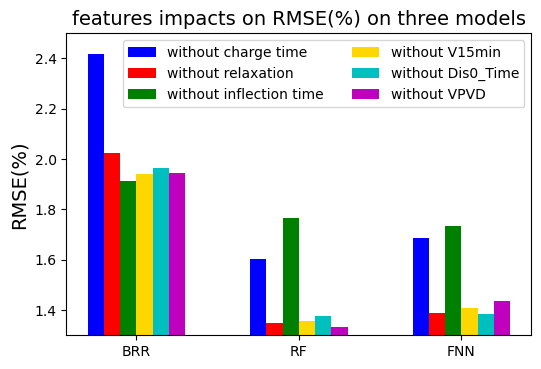

In [3]:
'''RMSE'''
import matplotlib.pyplot as plt

x1 = [-0.25, 0.75, 1.75]; x4 = ['BRR','RF','FNN']     # [1,2,3,4,5]；[-0.6,-0.4,-0.2,0.2,0.4,0.6]；['BRR','RF','FNN']；[-1.0, 2.0, 5.0]
x2 = [-0.15, 0.85, 1.85]; x5 = [0.15, 1.15, 2.15]
x3 = [-0.05, 0.95, 1.95]; x6 = [0.25, 1.25, 2.25]
lim = 1.3
h1_chr = [2.419-lim, 1.604-lim, 1.685-lim]         # 第1組數據高度 , bottom=0.94
h2_rex = [2.024-lim, 1.348-lim, 1.390-lim]         # 第2組數據高度 , bottom=0.94
h3_inf = [1.915-lim, 1.767-lim, 1.734-lim]         # 第3組數據高度 , bottom=0.94
h4_v15 = [1.939-lim, 1.358-lim, 1.408-lim]         # 第3組數據高度 , bottom=0.94
h5_dis = [1.966-lim, 1.378-lim, 1.383-lim]         # 第3組數據高度 , bottom=0.94
h6_vpv = [1.944-lim, 1.331-lim, 1.437-lim]         # 第3組數據高度 , bottom=0.94 ,dpi=300,fontsize=10

plt.figure(dpi=100)
plt.bar(x1, h1_chr, color='b', bottom=lim, width=0.1, label='without charge time')
plt.bar(x2, h2_rex, color='r', bottom=lim, width=0.1, label='without relaxation')
plt.bar(x3, h3_inf, color='g', bottom=lim, width=0.1, label='without inflection time')
plt.bar(x4, h4_v15, color='gold', bottom=lim, width=0.1, label='without V15min', align='edge')
plt.bar(x5, h5_dis, color='c', bottom=lim, width=0.1, label='without Dis0_Time')
plt.bar(x6, h6_vpv, color='m', bottom=lim, width=0.1, label='without VPVD')
plt.ylim(lim,2.5)
plt.ylabel('RMSE(%)', fontsize=14)
plt.title('features impacts on RMSE(%) on three models', fontsize=14)   #\n
plt.tick_params(labelsize=10)
plt.legend(fontsize=10, ncol=2);
plt.show()

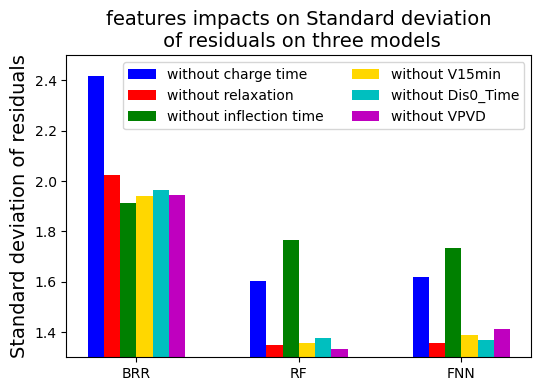

In [4]:
'''Standard deviation of residuals'''
import matplotlib.pyplot as plt

x1 = [-0.25, 0.75, 1.75]; x4 = ['BRR','RF','FNN']     # [1,2,3,4,5]；[-0.6,-0.4,-0.2,0.2,0.4,0.6]；['BRR','RF','FNN']；[-1.0, 2.0, 5.0]
x2 = [-0.15, 0.85, 1.85]; x5 = [0.15, 1.15, 2.15]
x3 = [-0.05, 0.95, 1.95]; x6 = [0.25, 1.25, 2.25]
lim = 1.3
h1_chr = [2.4189-lim, 1.6043-lim, 1.618-lim]         # 第1組數據高度 , bottom=0.94
h2_rex = [2.0240-lim, 1.3485-lim, 1.357-lim]         # 第2組數據高度 , bottom=0.94
h3_inf = [1.9145-lim, 1.7673-lim, 1.733-lim]         # 第3組數據高度 , bottom=0.94
h4_v15 = [1.9393-lim, 1.3577-lim, 1.390-lim]         # 第3組數據高度 , bottom=0.94
h5_dis = [1.9660-lim, 1.3781-lim, 1.370-lim]         # 第3組數據高度 , bottom=0.94
h6_vpv = [1.9439-lim, 1.3311-lim, 1.411-lim]         # 第3組數據高度 , bottom=0.94 ,dpi=300,fontsize=10

plt.figure(dpi=100)
plt.bar(x1, h1_chr, color='b', bottom=lim, width=0.1, label='without charge time')
plt.bar(x2, h2_rex, color='r', bottom=lim, width=0.1, label='without relaxation')
plt.bar(x3, h3_inf, color='g', bottom=lim, width=0.1, label='without inflection time')
plt.bar(x4, h4_v15, color='gold', bottom=lim, width=0.1, label='without V15min', align='edge')
plt.bar(x5, h5_dis, color='c', bottom=lim, width=0.1, label='without Dis0_Time')
plt.bar(x6, h6_vpv, color='m', bottom=lim, width=0.1, label='without VPVD')
plt.ylim(lim,2.5)
plt.ylabel('Standard deviation of residuals', fontsize=14)
plt.title('features impacts on Standard deviation\n of residuals on three models', fontsize=14)   #\n
plt.tick_params(labelsize=10)
plt.legend(fontsize=10, ncol=2);
plt.show()

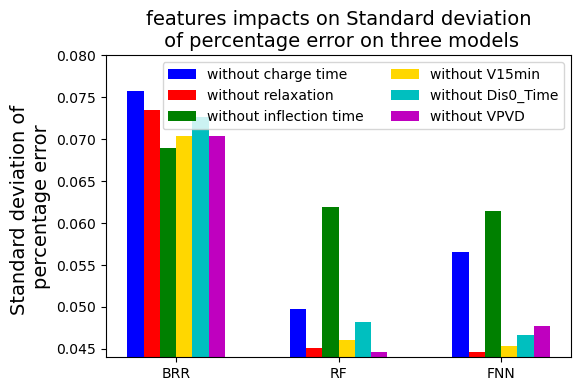

In [6]:
'''Standard deviation of percentage error'''
import matplotlib.pyplot as plt

x1 = [-0.25, 0.75, 1.75]; x4 = ['BRR','RF','FNN']     # [1,2,3,4,5]；[-0.6,-0.4,-0.2,0.2,0.4,0.6]；['BRR','RF','FNN']；[-1.0, 2.0, 5.0]
x2 = [-0.15, 0.85, 1.85]; x5 = [0.15, 1.15, 2.15]
x3 = [-0.05, 0.95, 1.95]; x6 = [0.25, 1.25, 2.25]
lim = 0.044
h1_chr = [0.0758-lim, 0.0497-lim, 0.0566-lim]         # 第1組數據高度 , bottom=0.94
h2_rex = [0.0735-lim, 0.0451-lim, 0.0446-lim]         # 第2組數據高度 , bottom=0.94
h3_inf = [0.0689-lim, 0.0619-lim, 0.0614-lim]         # 第3組數據高度 , bottom=0.94
h4_v15 = [0.0704-lim, 0.0461-lim, 0.0454-lim]         # 第3組數據高度 , bottom=0.94
h5_dis = [0.0727-lim, 0.0482-lim, 0.0466-lim]         # 第3組數據高度 , bottom=0.94
h6_vpv = [0.0704-lim, 0.0446-lim, 0.0477-lim]         # 第3組數據高度 , bottom=0.94 ,dpi=300,fontsize=10

plt.figure(dpi=100)
plt.bar(x1, h1_chr, color='b', bottom=lim, width=0.1, label='without charge time')
plt.bar(x2, h2_rex, color='r', bottom=lim, width=0.1, label='without relaxation')
plt.bar(x3, h3_inf, color='g', bottom=lim, width=0.1, label='without inflection time')
plt.bar(x4, h4_v15, color='gold', bottom=lim, width=0.1, label='without V15min', align='edge')
plt.bar(x5, h5_dis, color='c', bottom=lim, width=0.1, label='without Dis0_Time')
plt.bar(x6, h6_vpv, color='m', bottom=lim, width=0.1, label='without VPVD')
plt.ylim(lim,0.08)
plt.ylabel('Standard deviation of \npercentage error', fontsize=14)
plt.title('features impacts on Standard deviation\n of percentage error on three models', fontsize=14)   #\n
plt.tick_params(labelsize=10)
plt.legend(fontsize=10, ncol=2);
plt.show()

# 網路上範例

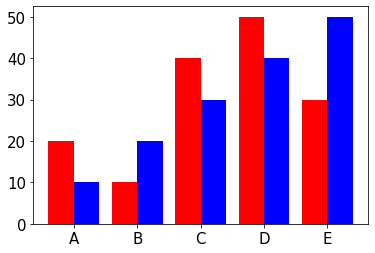

In [29]:
'''網路上範例'''
x = ['A','B','C','D','E']
x2 = [0.8-1,1.8-1,2.8-1,3.8-1,4.8-1]   # 因為長條圖寬度 0.4，所以位移距離為除以 2 為 0.2
h = [10,20,30,40,50]         # 第一組數據高度
h2 = [20,10,40,50,30]        # 第二組數據高度
plt.bar(x,h,color='b',width=0.4, align='edge')  # 第一組數據靠左邊緣對齊
plt.bar(x2,h2,color='r',width=0.4)              # 第二組數據置中對齊
plt.show()